###### 1. Data Input

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from patsy import dmatrices
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

if __name__ == '__main__':
    path_rein9 = r'C:\Users\rein9'
    path_rein = r'C:\Users\Rein'
    usr_path = path_rein9 if os.path.exists(path_rein9) == True else path_rein
    train_path = os.path.join(usr_path, r'.kaggle\competitions\titanic', 'train.csv')
    test_path = os.path.join(usr_path, r'.kaggle\competitions\titanic', 'test.csv')
    
    traindata = pd.read_csv('creditcard_train.csv')
    testdata = pd.read_csv('creditcard_test.csv')

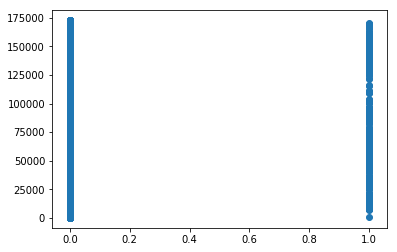

In [2]:
plt.scatter(traindata.Class, traindata.Time)
# probably not going to use the Time feature

Text(0,0.5,'Frequency')

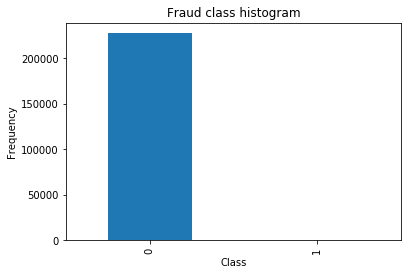

In [3]:
# traindata.Time[traindata.Class == 0].hist()
count_classes = pd.value_counts(traindata['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

### The data is clearly off balance!!!

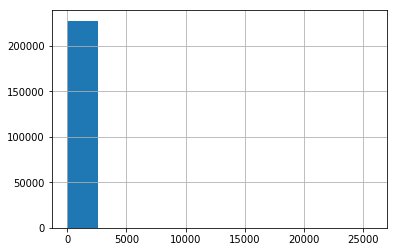

In [4]:
# normalize Amount
from sklearn.preprocessing import StandardScaler
traindata.Amount.hist()
traindata['normAmount'] = StandardScaler().fit_transform(traindata.Amount.values.reshape((-1,1)))

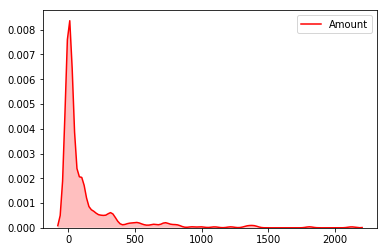

In [5]:
import seaborn as sns
traindata.head()
sns.kdeplot(traindata.Amount[traindata.Class == 1],shade=True,color="red")

In [6]:
# target = traindata.iloc[:,-1]
target = np.ravel(traindata.Class)
features = traindata.iloc[:, 2:-2]
traindata = traindata.drop(['Id', 'Amount', 'Time'], axis =1)
X = traindata.drop(['Class'], axis =1)
y = traindata.Class

# Undersample the data to balance out the dataset where Class == 1/0 is 0.5/0.5

In [93]:
ratio = 150
def undersample(traindata, ration):
    fraud_occur= len(traindata.Class[traindata.Class == 1])
    fraud_indices = np.array(traindata.Class[traindata.Class == 1].index)

    # randomly pick the same number of no fraud cases to balance out the data
    normal_indices = traindata[traindata.Class == 0].index
    randnorm_indices = np.array(np.random.choice(normal_indices, fraud_occur*ratio, replace = False))

    undersample_id = np.concatenate([fraud_indices, randnorm_indices])
    undersample_data = traindata.iloc[undersample_id, :]
    X_undersample = X.iloc[undersample_id, :]
    y_undersample = y.iloc[undersample_id]
#     test_id = list(traindata.index).remove(undersample_id)
    X_test = X.drop(randnorm_indices, axis = 0)
    y_test = y.drop(randnorm_indices)
    print('Total Number of res data: %d' %  (len(undersample_data)))
    print("Percentage of normal transactions: ", len(undersample_data[undersample_data.Class == 0])/len(undersample_data))
    print("Percentage of fraud transactions: ", len(undersample_data[undersample_data.Class == 1])/len(undersample_data))
    #Splitting the resampled data with both original dataset and resampled
    return X_undersample, X_test, y_undersample, y_test
X_trainres, X_testres, y_trainres, y_testres = undersample(traindata, ratio)
print(X_trainres.shape, X_testres.shape, y_trainres.shape, y_testres.shape)

Total Number of res data: 59645
Percentage of normal transactions:  0.9933774834437086
Percentage of fraud transactions:  0.006622516556291391
(59645, 29) (168539, 29) (59645,) (168539,)


Try: Logistic regression classifier with Undersampled data; 
    Due to the imbalance of the data, it is pretty much meaningless of the prediction.
  1) Need to increase recall
  2) Apply a cost function when having FN and FP with different weights for each type of error 

In [94]:
c_range = [0.01, 0.1, 1, 10, 100]
fscore_res = []
for i, c_param in enumerate(c_range):
    print('-------------------------------------------')
    print('C parameter: ', c_param)
    print('-------------------------------------------')
    print('')
#     clf = LogisticRegression(C = c_param, solver = 'lbfgs')
    clf = LogisticRegression(C = c_param, penalty = 'l1')
    clf.fit(X_trainres, y_trainres.values.ravel())
    lr_ptrain = clf.predict(X_trainres)
    fscore_res.append(f1_score(y_trainres, lr_ptrain))
    print('Logistic Regression Accuracy:{0:.3f}'.format(accuracy_score(y_trainres, lr_ptrain), ''))
    print('Recall Score for Logistic Regression\n')
    print(recall_score(y_trainres, lr_ptrain), '\n')
    print('F1 score for Logistic Regression\n')
    print(f1_score(y_trainres, lr_ptrain), '\n')
print(fscore_res)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Logistic Regression Accuracy:0.997
Recall Score for Logistic Regression

0.6683544303797468 

F1 score for Logistic Regression

0.7776141384388806 

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Logistic Regression Accuracy:0.998
Recall Score for Logistic Regression

0.7518987341772152 

F1 score for Logistic Regression

0.8330995792426368 

-------------------------------------------
C parameter:  1
-------------------------------------------

Logistic Regression Accuracy:0.998
Recall Score for Logistic Regression

0.7620253164556962 

F1 score for Logistic Regression

0.8396094839609484 

-------------------------------------------
C parameter:  10
-------------------------------------------

Logistic Regression Accuracy:0.998
Recall Score for Logistic Regression

0.7620253164556962 

F1 score for Logistic Regression


In [95]:
cfs_final= c_range[np.argmax(fscore_res)]
print(cfs_final)

10


#  Add feature selection

In [106]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
print(X.columns)
lr_filter = SelectKBest(f_regression, k = 8)
final_clf = LogisticRegression(C=cfs_final, penalty = 'l1')
lr_svm = Pipeline([('anova', lr_filter), ('svc', final_clf)])
lr_svm.set_params(anova__k=10, svc__C=10).fit(X_trainres, y_trainres.values.ravel())

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'normAmount'],
      dtype='object')


Pipeline(memory=None,
     steps=[('anova', SelectKBest(k=10, score_func=<function f_regression at 0x000001BF8AC0E488>)), ('svc', LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [50]:
lr_ptest = lr_svm.predict(X_testres)
tp = 0
fp = 0
fn = 0
# f1_score = 2*TP / (2*TP + FP + FN)
for i in range(len(y_testres)):
    if y_testres.iloc[i] == 1 and lr_ptest[i] == 1:
        tp += 1
    if y_testres.iloc[i] == 0 and lr_ptest[i] == 1:
        fp += 1
    if y_testres.iloc[i] == 1 and lr_ptest[i] == 0:
        fn += 1
f1_score = float(2*tp/(2*tp+fp+fn))
print(f1_score, tp, fp, fn)

0.0 0 40 0


In [107]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
# final_clf = LogisticRegression(C=cfs_final, penalty = 'l1')
# final_clf.fit(X_trainres, y_trainres.values.ravel())
# lr_ptest = final_clf.predict(X_testres)
lr_ptest = lr_svm.predict(X_testres)
print('Logistic Regression Accuracy:{0:.3f}'.format(accuracy_score(y_testres, lr_ptest), ''))
print('Recall Score for Logistic Regression\n')
print(recall_score(y_testres, lr_ptest), '\n')
print('F1 score for Logistic Regression\n')
print(f1_score(y_testres, lr_ptest), '\n')

Logistic Regression Accuracy:0.999
Recall Score for Logistic Regression

0.7544303797468355 

F1 score for Logistic Regression

0.8021534320323016 



In [74]:
ksel = lr_svm.named_steps['anova'].get_support()
features = pd.DataFrame(list(zip(X.columns, ksel)))
features = features[0][features[1] == True]

In [75]:
# reduced_test = testdata.drop(['Id', 'Amount', 'Time'], axis = 1)
reduced_test['normAmount'] = StandardScaler().fit_transform(testdata.Amount.values.reshape((-1,1)))
# pred = final_clf.predict(reduced_test[features])
pred = lr_svm.predict(reduced_test)
print(reduced_test.shape[0])
print(sum(pred[pred==1]))
solution = pd.DataFrame({'Id': testdata.Id, 'Class': pred})

57018
95


In [76]:
solution.to_csv('rw_submission_lrover.csv', index = False, columns = ['Id', 'Class'])

In [77]:
olddata = pd.read_csv('rw_submission_76tree.csv')
diff = 0

for i in range(len(olddata)):
    if solution.Class.values[i] != olddata.Class.values[i]:
        diff += 1
print(diff)

28


### Using Decision Tree 

In [ ]:
from sklearn import tree
ctree = tree.DecisionTreeClassifier(criterion='gini', max_depth = 10, max_leaf_nodes= X_trainres.shape[1])
ctree.fit(X_trainres, y_trainres.values.ravel())
tree_ptest = ctree.predict(X_testres)
print('Decision Tree Classification Accuracy:{0:.3f}'.format(accuracy_score(y_testres, tree_ptest),'\n'))
print('Recall Score for Decision Tree Classification\n')
print(recall_score(y_testres, tree_ptest), '\n')
print('F1 Score for Decision Tree Classification\n')
print(f1_score(y_testres, tree_ptest), '\n')
print('Cross_val F1 score for Decision Tree Classification\n')
print(cross_val_score(ctree, X, y, cv = 5, scoring = 'f1'))

Decision Tree Classification Accuracy:0.999
Recall Score for Decision Tree Classification

0.8531645569620253 

F1 Score for Decision Tree Classification

0.8424999999999999 

Cross_val F1 score for Decision Tree Classification



In [87]:
tree_predfinal = ctree.predict(reduced_test)
print(reduced_test.shape[0])
print(sum(tree_predfinal[tree_predfinal==1]))
solution_tr = pd.DataFrame({'Id': testdata.Id, 'Class': tree_predfinal})

57018
101


In [66]:
diff = 0

for i in range(len(solution_tr)):
    if solution.Class.values[i] != solution_tr.Class.values[i]:
        diff += 1
print(diff)

34


In [ ]:
solution_tr.to_csv('rw_submission_dtover.csv', index = False, columns = ['Id', 'Class'])